## 1)
#### An explanation is given of what is the difference between cupy and numpy. How does cupy handle data transfers between CPU and GPU? (1 point)

Generally speaking, CuPy mimics Numpy and Scipy in terms of function names and types.\
For instance if existing Numpy code on the beginning with
```
import numpy as np -> import cupy as np
```
that would work the same but all calculus would be performed on GPU instead of CPU.

To be honest there is a list of all differences available in [there],\
for instance "Random methods support dtype argument",\
but for me it is not such important.


[there]:https://docs.cupy.dev/en/stable/user_guide/difference.html

The creation of the CuPy array implies its storage on one of the GPU devices.\

In [1]:
import cupy as cp
import numpy as np

data = [1, 2, 3]
data_gpu = cp.array(data)  # data on GPU
data_cpu = np.array(data)  # data on CPU

So, we can't transform CPU and GPU arrays together (implicitly).

In [2]:
# data_gpu + data_cpu  # error

To work with data on the CPU we need to transfer data back.

In [3]:
cp.asnumpy(data_gpu) + data_cpu  # move data on CPU and calculate on CPU

array([2, 4, 6])

To work with data on the GPU we can do this:

In [4]:
data_gpu + cp.asarray(data_cpu)  # move data on GPU and calc on GPU

array([2, 4, 6])

## 2) Function saxpy that runs on GPU using cupy is provided. (1 point)
## 3.  Graph (OX - size of arrays, OY - computation time) is given. Plot computation time of numpy and cupy implementations of saxpy.

In [5]:
import timeit
import matplotlib.pyplot as plt


def saxpy(x, y, a):
    return x * a + y

In [6]:
steps = 40
N_list = np.exp(np.linspace(2, 14, steps)).astype(int)
cp_performance = []
cp_problem_size = []
num_repeats = 1000

a = 7.0
for N in N_list:
    x = cp.random.random(N)
    y = cp.random.random(N)
    start_time = timeit.default_timer()

    for _ in range(num_repeats):
        saxpy(x, y, a)
    elapsed = (timeit.default_timer() - start_time) / num_repeats

    cp_performance.append(elapsed)
    cp_problem_size.append(x.nbytes)


np_performance = []
np_problem_size = []
for N in N_list:
    x = np.random.random(N)
    y = np.random.random(N)
    start_time = timeit.default_timer()

    for _ in range(num_repeats):
        saxpy(x, y, a)
    elapsed = (timeit.default_timer() - start_time) / num_repeats

    np_performance.append(elapsed)
    np_problem_size.append(x.nbytes)

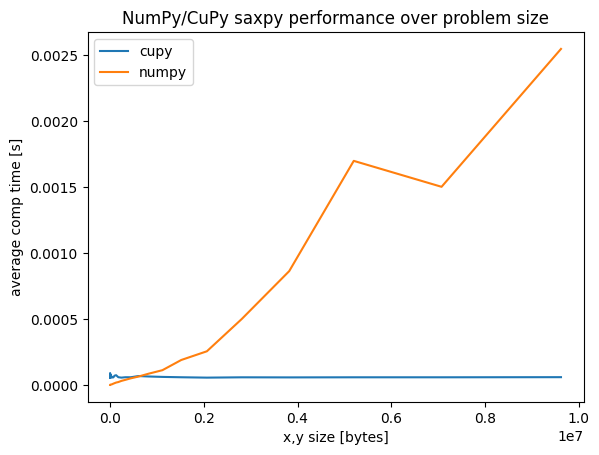

In [7]:
plt.plot(cp_problem_size, cp_performance, label="cupy")
plt.plot(np_problem_size, np_performance, label="numpy")
plt.title("NumPy/CuPy saxpy performance over problem size")
plt.legend()
plt.ylabel("average comp time [s]")
plt.xlabel("x,y size [bytes]")
plt.show()

## Bifurcation map

Cupy computes matrix multiplication, but the construction of an image is on NumPy.

In [8]:
%%writefile task8.py
from mpi4py import MPI
import time
import sys
import cupy
import numpy as np
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

time0 = time.time()

if sys.argv[2] =="cupy":
    engine = cupy
elif sys.argv[2] =="numpy":
    engine = np

def get_evolution_matrix(N_iter, rs, xs,engine):
    """
    From r_list,x_list, make tensor M_i = M[r_j,x_k,time_i]
    and make evolution of whole matrix as M_i = rs * M_(i-1) * (1-M_(i-1))
    return tensor M_i = M[r_j,x_k,time_i]
    """
    mat = engine.zeros((xs.shape[0], rs.shape[0], N_iter)) # float by default
    mat[:, :, 0] = engine.meshgrid(rs, xs)[1]
    for t in range(1, N_iter):
        mat[:, :, t] = rs * mat[:, :, t - 1] * (1 - mat[:, :, t - 1])
    if engine ==cupy:
        mat = cupy.asnumpy(mat)
    return mat

def get_last_m(mat, m, n):
    """
    From tensor M take elements from time_n to time_(n + m)

    """
    return mat[:, :, n : n + m]

N_iter = 100
resolution = int(sys.argv[1])

if engine == cupy:
    rs_total = cupy.linspace(0, 4, resolution) # float by default
    xs = cupy.linspace(0.001, 1, resolution,endpoint=False) # float by default
else:
    rs_total = np.linspace(0, 4, resolution) # float by default
    xs = np.linspace(0.001, 1, resolution,endpoint=False) # float by default


r_step = (resolution//size)

if rank == size-1:
    rs =rs_total[r_step * rank:]
else:
    rs = rs_total[r_step * rank:r_step * (rank+1)]


mat = get_evolution_matrix(N_iter, rs, xs,engine)

m = 10
last_mat = get_last_m(mat, m, N_iter - m)
last_mat = (last_mat * xs.shape[0]).astype(int)
img = np.zeros((last_mat.shape[0], last_mat.shape[1]), dtype=np.int64) + 1
for t in range(m):
    for i,col in enumerate(last_mat[:, :, t].T):
        converged_rows, counts = np.unique(col, return_counts=True)
        img[converged_rows,i] += counts

amode = MPI.MODE_WRONLY|MPI.MODE_CREATE
fh_result = MPI.File.Open(comm,f"./img_proc_{size}_res{resolution}_{sys.argv[2]}.txt", amode)
offset =  comm.Get_rank() * resolution * r_step * 8
fh_result.Write_at_all(offset, img.T.flatten())

fh_timer = MPI.File.Open(comm, f"./time_proc_{size}_res{resolution}_{sys.argv[2]}.txt", amode)

offset =  comm.Get_rank() * 4
timer = np.array([time.time() - time0],dtype= np.float32)
fh_timer.Write_at_all(offset, timer)

MPI.Finalize()

Overwriting task8.py


Cupy computes both the matrix multiplication and the construction of an image.

In [9]:
import time
import matplotlib

plt.rcParams["figure.figsize"] = (15, 7)


def calc_bif_map_GPU(resolution):
    time0 = time.time()

    def get_evolution_matrix(N_iter, rs, xs):
        """
        From r_list,x_list, make tensor M_i = M[r_j,x_k,time_i]
        and make evolution of whole matrix as M_i = rs * M_(i-1) * (1-M_(i-1))
        return tensor M_i = M[r_j,x_k,time_i]
        """
        mat = cp.zeros((xs.shape[0], rs.shape[0], N_iter))  # float by default
        mat[:, :, 0] = cp.meshgrid(rs, xs)[1]
        for t in range(1, N_iter):
            mat[:, :, t] = rs * mat[:, :, t - 1] * (1 - mat[:, :, t - 1])
        return mat

    def get_last_m(mat, m, n):
        """
        From tensor M take elements from time_n to time_(n + m)

        """
        return mat[:, :, n : n + m]

    N_iter = 100

    rs = cp.linspace(0, 4, resolution)  # float by default
    xs = cp.linspace(0.001, 1, resolution, endpoint=False)  # float by default

    mat = get_evolution_matrix(N_iter, rs, xs)

    m = 10
    last_mat = get_last_m(mat, m, N_iter - m)
    last_mat = (last_mat * xs.shape[0]).astype(int)
    img = cp.zeros((last_mat.shape[0], last_mat.shape[1]), dtype=cp.int64) + 1
    for t in range(m):
        for i, col in enumerate(last_mat[:, :, t].T):
            converged_rows, counts = cp.unique(col, return_counts=True)
            img[converged_rows, i] += counts
    timer = cp.array([time.time() - time0], dtype=cp.float32)
    return img, timer

## 4). Bifurcation map is performed using cupy arrays.

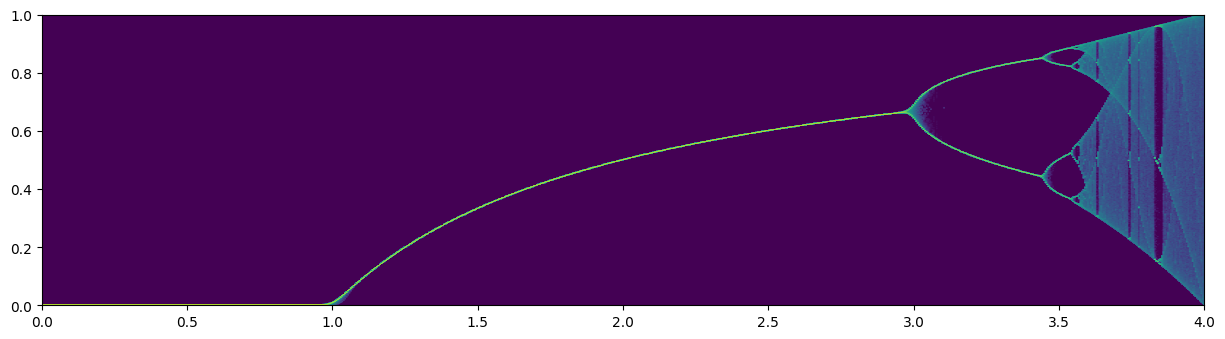

In [10]:
x, t = calc_bif_map_GPU(800)
x = cp.asnumpy(x)
plt.imshow(
    x,
    norm=matplotlib.colors.LogNorm(),
    extent=[0, 4, 1, 0],
)
plt.gca().invert_yaxis()

## 5. Graph (OX - number of rs, OY - computation time) is given. Plot computation time of CPU, CPU parallel, and GPU implementations. 

In [11]:
############### CPU #################
resolution = 1000
for proc in range(1,8):
    !mpirun -n {proc} python task8.py {resolution} "numpy"

speedup_numpy = []
for proc in range(1,8):
    speedup_numpy.append(np.mean(np.fromfile(f"time_proc_{proc}_res{resolution}_numpy.txt", dtype=np.float32)))
    
############### GPU #################
!mpirun -n 1 python task8.py {resolution} "cupy"
speedup_cupy = np.fromfile(f"time_proc_1_res{resolution}_cupy.txt", dtype=np.float32)
_, speedup_pure_cupy = calc_bif_map_GPU(resolution)

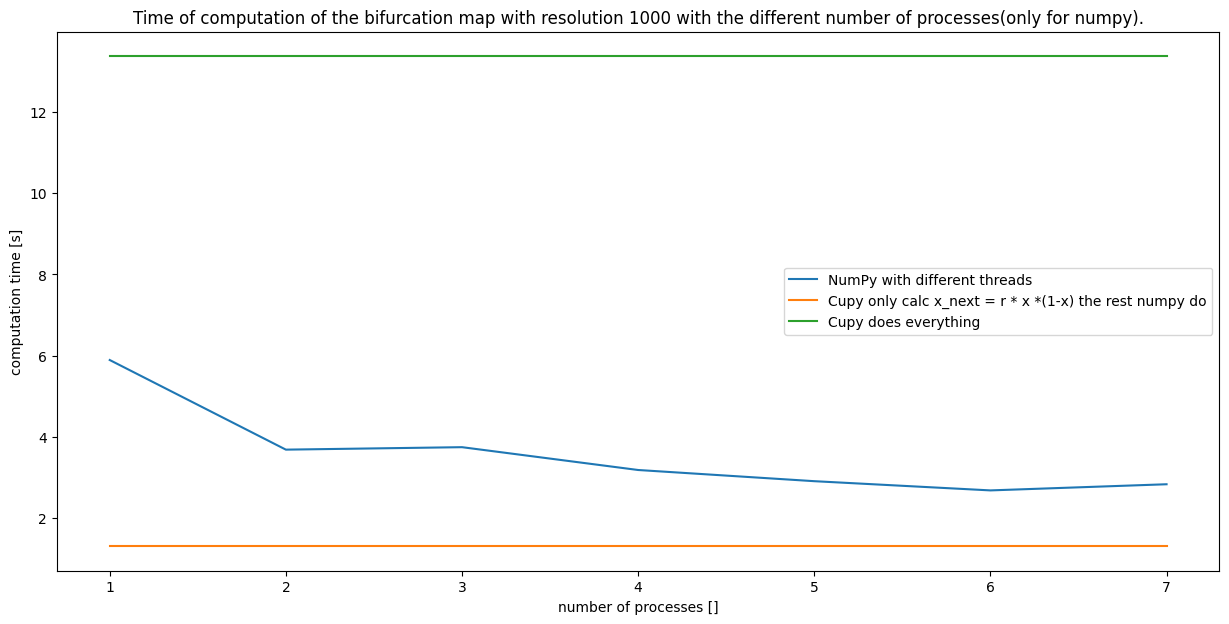

In [12]:
plt.plot(range(1, 8), speedup_numpy, label="NumPy with different threads")
plt.plot(
    range(1, 8),
    speedup_cupy.tolist() * 7,
    label="Cupy only calc x_next = r * x *(1-x) the rest numpy do",
)
plt.plot(
    range(1, 8),
    speedup_pure_cupy.tolist() * 7,
    label="Cupy does everything ",
)
plt.title(
    f"Time of computation of the bifurcation map with resolution {resolution} with the different number of processes(only for numpy)."
)
plt.xlabel("number of processes []")
plt.ylabel("computation time [s]")
plt.legend()
plt.show()

The major problem that I found - is the generation of an image from converged matrices. That procedure requires finding unique elements and counting them. "Cupy does everything" also generates the image on GPU, which works worse than other options.